## **Import libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score, make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#TODO: SAVE EACH MODEL IN A SEPARATE FILE

## **Upload dataset**

In [14]:
dataset = pd.read_csv('DSL-StrongPasswordData.csv')
dataset = dataset.drop(columns=['sessionIndex', 'rep'])

# Map subjects to numbers
subject_mapping = {}
unique_subjects = dataset['subject'].unique()
for i, subject in enumerate(unique_subjects):
    subject_mapping[subject] = i

dataset['subject'] = dataset['subject'].map(subject_mapping)

# 20400 x 34 
# print(dataset.iloc[0:1,:])

In [20]:
from sklearn.model_selection import train_test_split

# Split dataset into users and impostors
num_classes = len(np.unique(dataset['subject']))

user = {}
impostor = {}
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for i in range(num_classes):
    user[i] = dataset.loc[dataset['subject'] == i]
    impostor[i] = dataset.loc[dataset['subject'] != i]
    # scale impostor to the same size as user
    impostor[i] = impostor[i].sample(n=len(user[i]))

    user[i].loc[:, 'subject'] = 0
    impostor[i].loc[:, 'subject'] = 1

    merged_data = pd.concat([user[i], impostor[i]])
    
    X = merged_data.loc[:, 'H.period':'H.Return']
    y = merged_data['subject']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

#### Hold Duration, Down-Down Duration and Up-Down Duration plots

/Users/zpietrza/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/zpietrza/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/zpietrza/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/zpietrza/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 11.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/zpietrza/anaconda3/lib/python3.11/site-packages/se

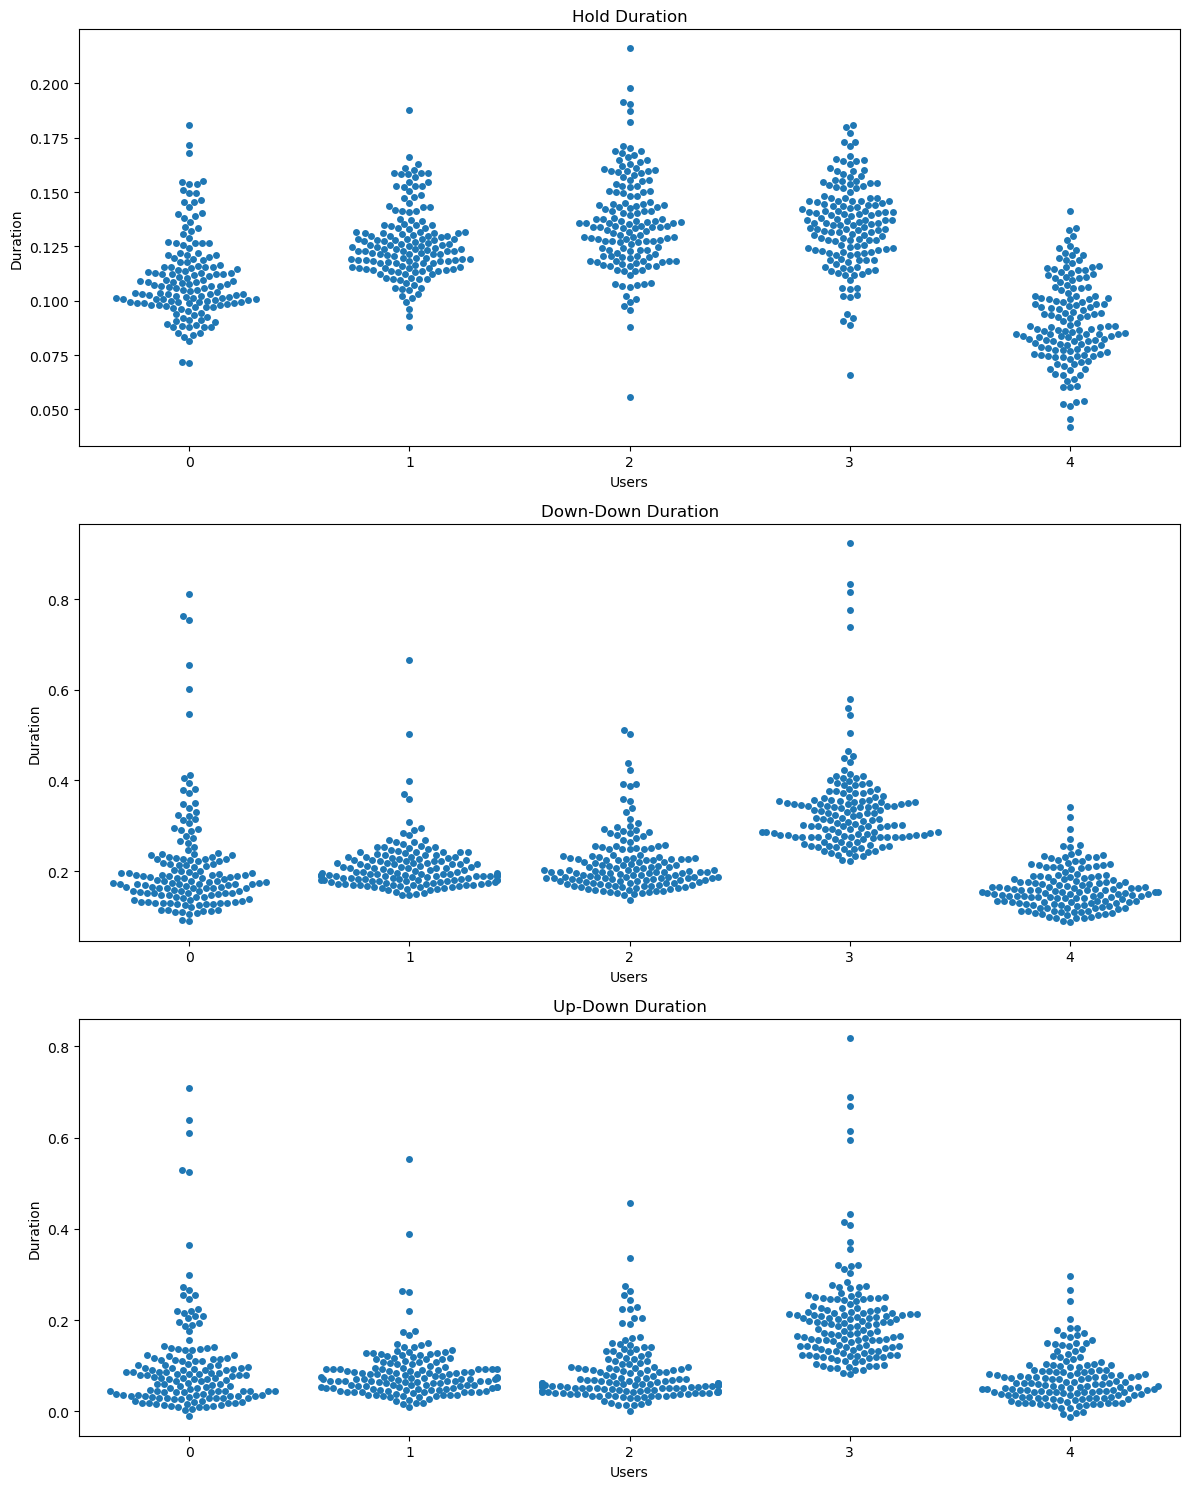

In [24]:
import seaborn as sns

unique_subjects = dataset['subject'].unique()
selected_subjects = unique_subjects[:5]

# Randomly select one row for each of the unique subjects
selected_data = dataset[dataset['subject'].isin(selected_subjects)].groupby('subject').sample(150)

fig, axes = plt.subplots(3, 1, figsize=(12, 15))
subplot_names = ["Hold Duration", "Down-Down Duration", "Up-Down Duration"]

for i, (col_name, marker) in enumerate([("H.Shift.r", 'o'), ("DD.Shift.r.o", 'o'), ("UD.Shift.r.o", 'o')]):
    ax = axes[i]
    ax.set_title(subplot_names[i]) 
    ax.set_xlabel('Users')
    ax.set_ylabel('Duration')

    # Create a subset of data with only the selected feature
    subset_data = selected_data[['subject', col_name]]

    sns.swarmplot(data=subset_data, x='subject', y=col_name, ax=ax, marker=marker)

plt.tight_layout()
plt.show()


#### Feature importance

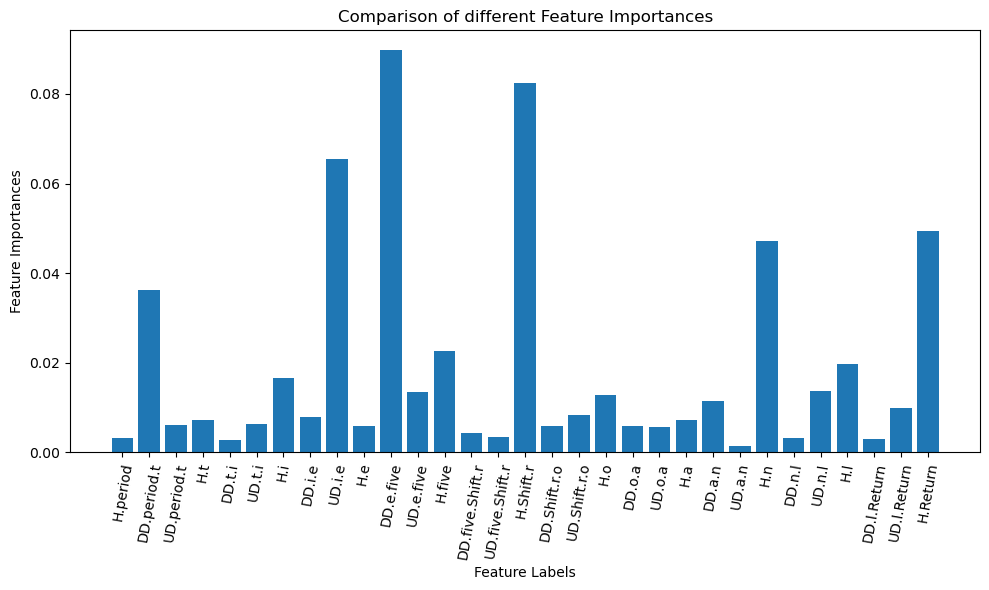

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 30)

extra_tree_forest.fit(X, y)

feature_importance = extra_tree_forest.feature_importances_

feature_importance_normalized = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], axis = 0)

plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance_normalized)
plt.xticks(rotation=80)

plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.tight_layout()
plt.show()

# **Random Forest**

### Hyperparameters tuning

#### Randomized Search

In [30]:
from sklearn.ensemble import RandomForestClassifier
import random

best_models_random = []

hyperparams = {
        'n_estimators': np.arange(50, 150, step=10), # tested on 100-500, step=100 -> best = 100
        'max_depth': [None] + list(np.arange(10, 200, step=20)),
        'min_samples_split': np.arange(2, 20, step=2),
        'min_samples_leaf': [1, 2, 4], 
        'criterion': ['gini','entropy'],
        'max_features': ['log2', 'sqrt'],
        'bootstrap': [True, False]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:15]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier()

    random_search = RandomizedSearchCV(rf, hyperparams, cv=5, scoring='accurancy', n_jobs=-1, n_iter=20)
    random_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', random_search.best_params_)
    print('Best score: ', random_search.best_score_)

    best_model = random_search.best_estimator_
    best_models_random.append(best_model)

    # predictions = best_model.predict(X_test)

    # print(classification_report(y_test, predictions))

User  50
Best hyperparams: {'n_estimators': 130, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 30}
Best score:  0.9703125
User  10
Best hyperparams: {'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 150}
Best score:  0.9640625
User  43
Best hyperparams: {'n_estimators': 60, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_depth': 10}
Best score:  0.9671875
User  41
Best hyperparams: {'n_estimators': 90, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 190}
Best score:  0.9625
User  2
Best hyperparams: {'n_estimators': 80, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 190}
Best score:  0.9796875
User  45
Best hyperparams: {'n_estimators': 80, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 70}
Best score:  0.9984375
User  46
Best hyperparams: {'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 130}
Best score:  0.9859375
User  17
Best hyperparams: {'n_estimators': 50, 'mi

#### Grid Search

In [10]:
from sklearn.ensemble import RandomForestClassifier
import random

best_models_grid = []

hyperparams = {
        # random search did not find specific range for these
        # n_estimators and max_depth are the most ambiguous
        'n_estimators': np.arange(90, 100, step=2), # tested on 80-120, step=10 -> best ~= 96 
        'max_depth': [None] + list(np.arange(10, 50, step=10)), # tested on 10-200, step=20 -> best = 10
        'min_samples_split': np.arange(2, 20, step=2), # 2 -> best
        'min_samples_leaf': [1, 2], # 1 -> best

        # selected from random search
        'criterion': ['gini'],
        'max_features': ['log2'],
        'bootstrap': [False]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier()

    f1 = make_scorer(f1_score)

    grid_search = GridSearchCV(rf, hyperparams, cv=5, scoring=f1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', grid_search.best_params_)
    print('Best score: ', grid_search.best_score_)

    best_model = grid_search.best_estimator_
    best_models_grid.append(best_model)

    # predictions = best_model.predict(X_test)

    # print(classification_report(y_test, predictions))

User  4
Best hyperparams: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 92}
Best score:  0.9515625
User  42
Best hyperparams: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 92}
Best score:  1.0
User  21
Best hyperparams: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 92}
Best score:  0.9953125
User  23
Best hyperparams: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 92}
Best score:  0.971875
User  48
Best hyperparams: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 92}
Best score:  0.9890625
User

### Final model

In [10]:
from sklearn.ensemble import RandomForestClassifier

hyperparams = {
        'n_estimators': 92, 
        'max_depth': None, # allows for deeper trees to be grown, default
        'min_samples_split': 2, # default
        'min_samples_leaf': 1, # default
        'criterion': 'gini', # default
        'max_features': 'log2',
        'bootstrap': False
    }

predictions_list = []

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier(**hyperparams)
    rf.fit(X_train, y_train)

    predictions = rf.predict(X_test)
    predictions_list.append(predictions)

    f2_score = fbeta_score(y_test, predictions, beta=2)

    print("User: ", i)
    print(classification_report(y_test, predictions))
    print("F2 score: ", round(f2_score, 2))

User:  0
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        80
           1       0.96      1.00      0.98        80

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160

F2 score:  0.99
User:  1
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        80
           1       0.94      0.97      0.96        80

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160

F2 score:  0.97
User:  2
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        80
           1       0.95      1.00      0.98        80

    accuracy                           0.97       160
   macro avg       0.98      0.97      0.97       160
weighted avg   

Mean ROC AUC:  0.98


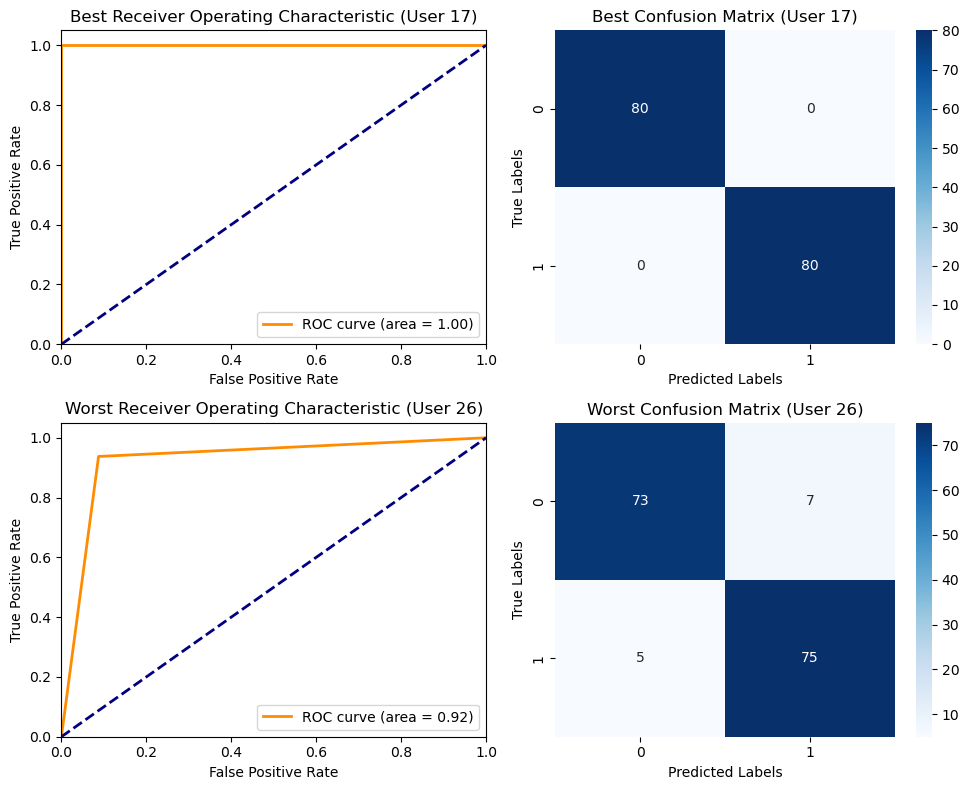

In [27]:
best_roc_auc = 0
worst_roc_auc = 1
mean_roc_auc = 0

best_user, worst_user = None, None
best_fpr, best_tpr, worst_fpr, worst_tpr = None, None, None, None
best_cm, worst_cm = None, None

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    predictions = predictions_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    mean_roc_auc += roc_auc

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_user = i
        best_fpr, best_tpr = fpr, tpr
        best_cm = confusion_matrix(y_test, predictions)

    if roc_auc < worst_roc_auc:
        worst_roc_auc = roc_auc
        worst_user = i
        worst_fpr, worst_tpr = fpr, tpr
        worst_cm = confusion_matrix(y_test, predictions)

mean_roc_auc /= num_classes

print("Mean ROC AUC: ", round(mean_roc_auc, 2))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.sca(axes[0, 0])
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Best Receiver Operating Characteristic (User {best_user})')
plt.legend(loc="lower right")

plt.sca(axes[0, 1])
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Best Confusion Matrix (User {best_user})')

plt.sca(axes[1, 0])
plt.plot(worst_fpr, worst_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {worst_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Worst Receiver Operating Characteristic (User {worst_user})')
plt.legend(loc="lower right")

plt.sca(axes[1, 1])
sns.heatmap(worst_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Worst Confusion Matrix (User {worst_user})')

plt.tight_layout()
plt.show()

# **K Nearest Neighbors**

### Hyperparameters tuning

#### Randomized Search

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import random

best_models_random = []

hyperparams = {
        'n_neighbors': list(range(2, 21)), # tested on 2-100
        'leaf_size': list(range(1, 16)), # tested on 1-30
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    knn = KNeighborsClassifier()

    random_search = RandomizedSearchCV(knn, hyperparams, cv=5, scoring='accurancy', n_jobs=-1, n_iter=10)
    random_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', random_search.best_params_)
    print('Best score: ', random_search.best_score_)

    best_model = random_search.best_estimator_
    best_models_random.append(best_model)

    predictions = best_model.predict(X_test)

    #print(classification_report(y_test, predictions))

User  12
Best hyperparams: {'weights': 'distance', 'p': 2, 'n_neighbors': 2, 'leaf_size': 13}
Best score:  0.9609375
User  33
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors': 4, 'leaf_size': 3}
Best score:  0.9328125
User  1
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors': 6, 'leaf_size': 14}
Best score:  0.9484375
User  19
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors': 2, 'leaf_size': 3}
Best score:  0.9765625
User  29
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors': 4, 'leaf_size': 5}
Best score:  0.96875
User  26
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'leaf_size': 9}
Best score:  0.884375
User  40
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors': 6, 'leaf_size': 10}
Best score:  0.9671875
User  11
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors': 16, 'leaf_size': 8}
Best score:  0.9609375
User  16
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors'

#### Grid Search

In [14]:
best_models_grid = []

hyperparams = {
    'n_neighbors': list(range(2, 21)),
    'leaf_size': list(range(1, 16)),
    'weights': ['distance'],
    'p': [1]
}

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    knn = KNeighborsClassifier()

    f1 = make_scorer(f1_score)

    grid_search = GridSearchCV(knn, hyperparams, cv=5, scoring=f1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', grid_search.best_params_)
    print('Best score: ', grid_search.best_score_)

    best_model = grid_search.best_estimator_
    best_models_grid.append(best_model)

    predictions = best_model.predict(X_test)

    print(classification_report(y_test, predictions))

User  24
Best hyperparams: {'leaf_size': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best score:  0.970988312024191
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        80
           1       1.00      0.97      0.99        80

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

User  46
Best hyperparams: {'leaf_size': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best score:  1.0
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        80
           1       1.00      0.94      0.97        80

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160

User  9
Best hyperparams: {'leaf_size': 1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score:  0.96394

### Final model

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

hyperparams = {
    'n_neighbors': 2, # best for range 2-4
    'leaf_size': 1,
    'weights': 'distance',
    'p': 1 # manhattan distance
}

predictions_list = []

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    knn = KNeighborsClassifier(**hyperparams)
    knn.fit(X_train, y_train)

    predictions = knn.predict(X_test)
    predictions_list.append(predictions)

    f2_score = fbeta_score(y_test, predictions, beta=2)

    print("User: ", i)
    print(classification_report(y_test, predictions))
    print("F2 score: ", round(f2_score, 2))

User:  0
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        80
           1       0.97      0.82      0.89        80

    accuracy                           0.90       160
   macro avg       0.91      0.90      0.90       160
weighted avg       0.91      0.90      0.90       160

F2 score:  0.85
User:  1
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        80
           1       1.00      0.91      0.95        80

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160

F2 score:  0.93
User:  2
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        80
           1       1.00      0.90      0.95        80

    accuracy                           0.95       160
   macro avg       0.95      0.95      0.95       160
weighted avg   

Mean ROC AUC:  0.95


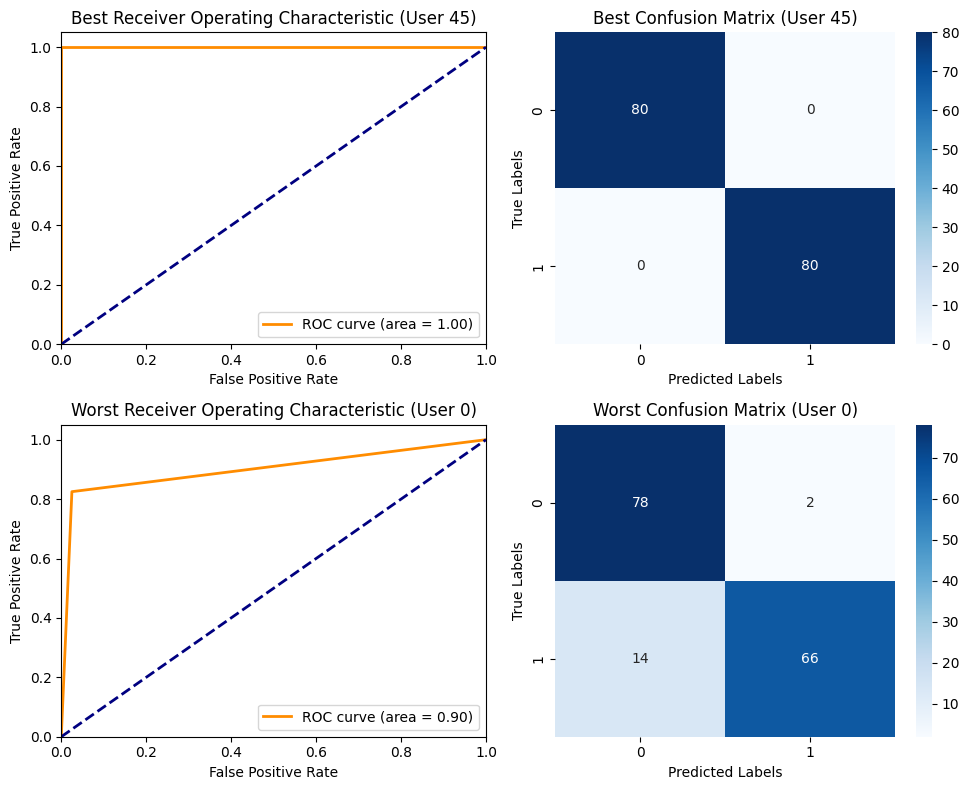

In [15]:
best_roc_auc = 0
worst_roc_auc = 1
mean_roc_auc = 0

best_user, worst_user = None, None
best_fpr, best_tpr, worst_fpr, worst_tpr = None, None, None, None
best_cm, worst_cm = None, None

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    predictions = predictions_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    mean_roc_auc += roc_auc

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_user = i
        best_fpr, best_tpr = fpr, tpr
        best_cm = confusion_matrix(y_test, predictions)

    if roc_auc < worst_roc_auc:
        worst_roc_auc = roc_auc
        worst_user = i
        worst_fpr, worst_tpr = fpr, tpr
        worst_cm = confusion_matrix(y_test, predictions)

mean_roc_auc /= num_classes

print("Mean ROC AUC: ", round(mean_roc_auc, 2))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.sca(axes[0, 0])
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Best Receiver Operating Characteristic (User {best_user})')
plt.legend(loc="lower right")

plt.sca(axes[0, 1])
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Best Confusion Matrix (User {best_user})')

plt.sca(axes[1, 0])
plt.plot(worst_fpr, worst_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {worst_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Worst Receiver Operating Characteristic (User {worst_user})')
plt.legend(loc="lower right")

plt.sca(axes[1, 1])
sns.heatmap(worst_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Worst Confusion Matrix (User {worst_user})')

plt.tight_layout()
plt.show()

# **Neutral Network**

In [ ]:
%pip install tensorflow

#### Model

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

predictions_list = []
history_list = []

X_test_list_nn = []
y_test_list_nn = []

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    # train: 70%, validation: 20%, test: 10%
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp) 

    X_test_list_nn.append(X_test)
    y_test_list_nn.append(y_test)

    model = Sequential()

    model.add(Dense(300, input_dim=31, activation='relu')) # input layer - input_dim = number of features
    model.add(Dropout(0.5)) # dropout layer - really important - with lower values there are bigger validation losses
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1, activation='sigmoid')) # output layer - 1 neuron as it is binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=100, verbose=0)
    history_list.append(history)

    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)
    predictions_list.append(predictions)

    f2_score = fbeta_score(y_test, predictions, beta=2)

    print("User: ", i)
    print(classification_report(y_test, predictions))
    print("F2 score: ", round(f2_score, 2))

3/3 [==============================] - 0s 4ms/step
User:  0
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        40
           1       0.89      0.97      0.93        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.92        80

F2 score:  0.96
3/3 [==============================] - 0s 3ms/step
User:  1
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.95      0.95      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

F2 score:  0.95
3/3 [==============================] - 0s 2ms/step
User:  2
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        40
           1       0.93  

#### Diagrams

Mean ROC AUC:  0.95


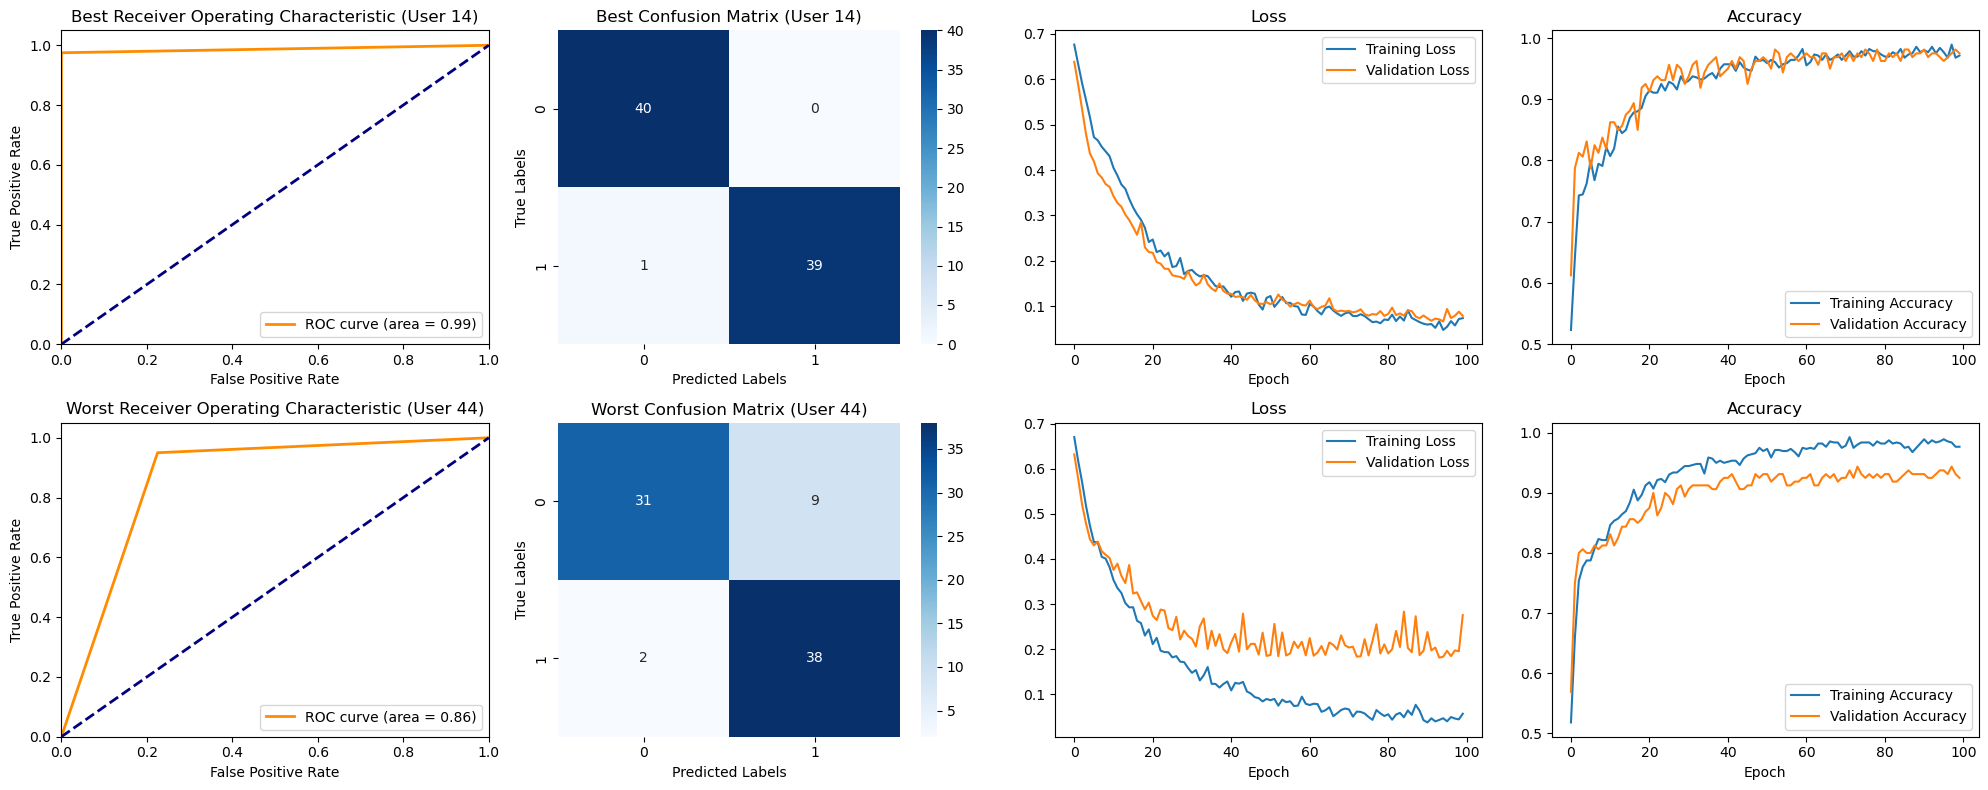

In [22]:
best_roc_auc = 0
worst_roc_auc = 1
mean_roc_auc = 0

best_user, worst_user = None, None
best_fpr, best_tpr, worst_fpr, worst_tpr = None, None, None, None
best_cm, worst_cm = None, None
best_history, worst_history = None, None

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list_nn[i]
    y_train = y_train_list[i]
    y_test = y_test_list_nn[i]

    predictions = predictions_list[i]
    history = history_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    mean_roc_auc += roc_auc

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_user = i
        best_fpr, best_tpr = fpr, tpr
        best_cm = confusion_matrix(y_test, predictions)
        best_history = history

    if roc_auc < worst_roc_auc:
        worst_roc_auc = roc_auc
        worst_user = i
        worst_fpr, worst_tpr = fpr, tpr
        worst_cm = confusion_matrix(y_test, predictions)
        worst_history = history

mean_roc_auc /= num_classes

print("Mean ROC AUC: ", round(mean_roc_auc, 2))

fig, axes = plt.subplots(2, 4, figsize=(20, 8))

plt.sca(axes[0, 0])
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Best Receiver Operating Characteristic (User {best_user})')
plt.legend(loc="lower right")

plt.sca(axes[0, 1])
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Best Confusion Matrix (User {best_user})')

plt.sca(axes[0, 2])
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.sca(axes[0, 3])
plt.plot(best_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.sca(axes[1, 0])
plt.plot(worst_fpr, worst_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {worst_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Worst Receiver Operating Characteristic (User {worst_user})')
plt.legend(loc="lower right")

plt.sca(axes[1, 1])
sns.heatmap(worst_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Worst Confusion Matrix (User {worst_user})')

plt.sca(axes[1, 2])
plt.plot(worst_history.history['loss'], label='Training Loss')
plt.plot(worst_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.sca(axes[1, 3])
plt.plot(worst_history.history['accuracy'], label='Training Accuracy')
plt.plot(worst_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# TODO: Cross Validation
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True)

for train_index, val_index in kfold.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # model, layers
    model = ...

    model.fit(X_train, y_train, epochs=..., batch_size=..., validation_data=(X_val, y_val))

    scores = model.evaluate(X_val, y_val)
    print("Validation Accuracy: %.2f%%" % (scores[1] * 100))